In [1]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

# Data loading

In [2]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [4]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl') for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 1min 3s, sys: 5.19 s, total: 1min 8s
Wall time: 1min 8s


In [5]:
from tqdm import tqdm
import sys
import time

tqdm.pandas()

# Data selection

In [6]:
width = 100

ei_1 = [[],[]]


for i in range(width-1):
    if i+1 < width:
        ei_1[0].append(i)
        ei_1[0].append(i+1)
        ei_1[1].append(i+1)
        ei_1[1].append(i)

edge = torch.tensor(np.array(ei_1), dtype=torch.long)

In [7]:
class GraphDataset(Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels, intervals, 
                 transform=None, pre_transform=None, pre_filter=None):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels = labels
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        
        
            
        super().__init__(transform, pre_transform, pre_filter)

    def len(self):
        return len(self.intervals)

    def get(self, idx):
        interval = self.intervals[idx]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        X = torch.tensor(X, dtype=torch.float)
        

        y = self.labels[interval[0]][interval[1]: interval[2]]
        y = torch.tensor(y, dtype=torch.int64)
        
        return Data(x=X.unsqueeze(0),  y=y.unsqueeze(0))

In [8]:
np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 22464.38it/s]


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

labels = np.array([1]*len(ints_in) + [0]*len(ints_out))
chromes = [inter[0] for inter in equalized]
strat_labels = np.array([f"{label}_{chrom}" for label, chrom in zip(labels, chromes)])
print(strat_labels)
  
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_inds, test_inds = next(sss.split(equalized, strat_labels))
  
train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

['1_chr1' '1_chr1' '1_chr1' ... '0_chr18' '0_chr8' '0_chr6']


In [10]:
np.random.seed(42)
train_dataset = GraphDataset(chrom_names, feature_names,
                            DNA, DNA_features,
                            ZDNA, train_intervals)

test_dataset = GraphDataset(chrom_names, feature_names,
                           DNA, DNA_features,
                           ZDNA, test_intervals)

In [11]:
np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

# Train and test

In [12]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

np.random.seed(42)
def loss_func(output, y_batch):
    np.random.seed(42)
    return torch.nn.NLLLoss()(output, y_batch)


def train_epoch(model, optimizer):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()

    for dt in tqdm(loader_train, desc='Train'):
        x, y = dt.x.to('cuda:1'),  dt.y.to('cuda:1').long()
        
        optimizer.zero_grad()

        output = model(x)
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    y_pred)
            
            precision = precision_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
                          
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output.permute([0, 2, 1]), y)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log


def test(model):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()

    means = []
    for dt in tqdm(loader_test, desc='Test'):
        x, y = dt.x.to('cuda:1'), dt.y.to('cuda:1').long()
        

        output = model(x)
        means.append(y.sum().cpu() / (1.0 * y.shape[0]))
        pred = torch.argmax(output, dim=-1)
        
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    y_pred)
            
            precision = precision_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output.permute([0, 2, 1]), y)
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    np.random.seed(42)
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)

    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)

    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize),
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')

    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2),
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def train(model, opt, n_epochs):
    np.random.seed(42)
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        
        start_time = time.time()
        
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)
        
        end_time = time.time()
        
        t = end_time - start_time
        times.append(t)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))


        clear_output()
        plot_history(train_loss_log, val_loss_log, 'Loss', len(train_loss), n_epochs)
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss), n_epochs)
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss), n_epochs)
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss), n_epochs)
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss), n_epochs)
        print("Time: ", t/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))


    print("Final ROC-AUC = {:.4}".format(val_auc_log[-1]))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))

    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times

In [13]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [14]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

# Model

In [26]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.nn import BatchNorm1d

class GraphZSAGEConvBatchNorm(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvBatchNorm, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.bn1 = BatchNorm1d(100)  # BatchNorm после первого слоя
        self.conv2 = SAGEConv(500, 100)
        self.bn2 = BatchNorm1d(100)  # BatchNorm после второго слоя
        self.conv3 = SAGEConv(100, 2)
        # Не добавляем BatchNorm перед выходным слоем (логиты для классификации)

    def forward(self, x):  # Добавил edge как входной параметр
        x = self.conv1(x, edge.to('cuda:1'))
        x = self.bn1(F.relu(x))  # ReLU + BatchNorm
        x = self.conv2(x, edge.to('cuda:1'))
        x = self.bn2(F.relu(x))  # ReLU + BatchNorm
        x = self.conv3(x, edge.to('cuda:1'))  # Без BatchNorm перед выходом

        return F.log_softmax(x, dim=-1)

In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.nn import LayerNorm

class GraphZSAGEConvLayerNorm(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvLayerNorm, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.conv2 = SAGEConv(500, 100)
        self.conv3 = SAGEConv(100, 2)
        
        # Добавляем LayerNorm для каждого слоя
        self.norm1 = LayerNorm(500)
        self.norm2 = LayerNorm(100)
        

    def forward(self, x):
        # Первый слой: Conv -> Norm -> ReLU
        x = self.conv1(x, edge.to('cuda:1'))
        x = self.norm1(x)
        x = F.relu(x)
        
        # Второй слой: Conv -> Norm -> ReLU
        x = self.conv2(x, edge.to('cuda:1'))
        x = self.norm2(x)
        x = F.relu(x)
        
        # Третий слой: Conv -> Norm (без ReLU перед выходом)
        x = self.conv3(x, edge.to('cuda:1'))
       

        return F.log_softmax(x, dim=-1)

In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphZSAGEConvGroupNorm(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvGroupNorm, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.gn1 = torch.nn.GroupNorm(num_groups=50, num_channels=500)  
        self.conv2 = SAGEConv(500, 100)
        self.gn2 = torch.nn.GroupNorm(num_groups=10, num_channels=100)  
        self.conv3 = SAGEConv(100, 2)
        
    def forward(self, x): 
        x = self.conv1(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)  
        x = self.gn1(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        
        # Второй слой
        x = self.conv2(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)
        x = self.gn2(x)
        x = x.permute(0, 2, 1)
        x = F.relu(x)
        
        x = self.conv3(x, edge.to('cuda:1'))
        
        return F.log_softmax(x, dim=-1)

In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.nn import InstanceNorm1d

class GraphZSAGEConvInstanceNorm(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvInstanceNorm, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.norm1 = InstanceNorm1d(500)  # Нормализация для выхода conv1
        self.conv2 = SAGEConv(500, 100)
        self.norm2 = InstanceNorm1d(100)  # Нормализация для выхода conv2
        self.conv3 = SAGEConv(100, 2)
        # Для последнего слоя нормализацию обычно не добавляют

    def forward(self, x):
        # Первый слой
        x = self.conv1(x, edge.to('cuda:1'))
        x = self.norm1(x)  # InstanceNorm
        x = F.relu(x)
        
        # Второй слой
        x = self.conv2(x, edge.to('cuda:1'))
        x = self.norm2(x)  # InstanceNorm
        x = F.relu(x)
        
        # Третий слой (без нормализации)
        x = self.conv3(x, edge.to('cuda:1'))

        return F.log_softmax(x, dim=-1)

# Запуск GraphZSAGEConvBatchNorm

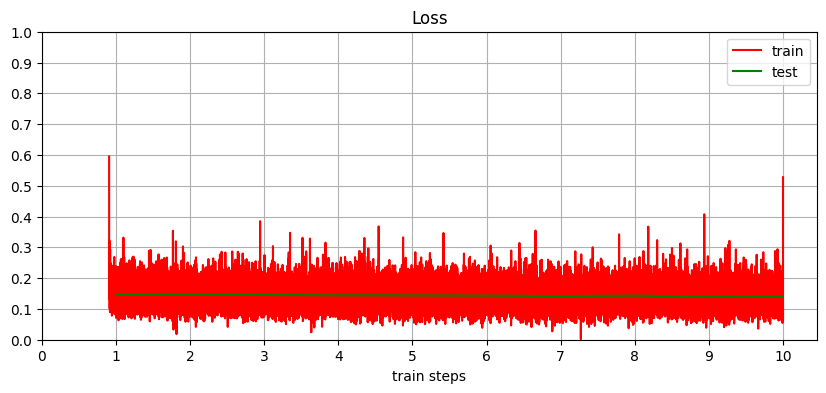

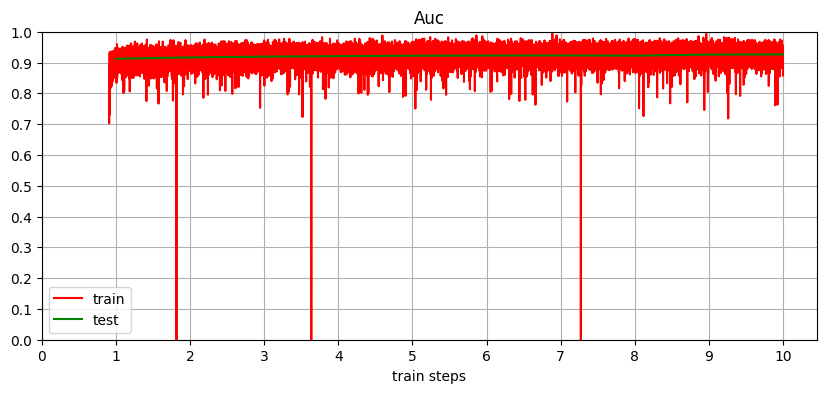

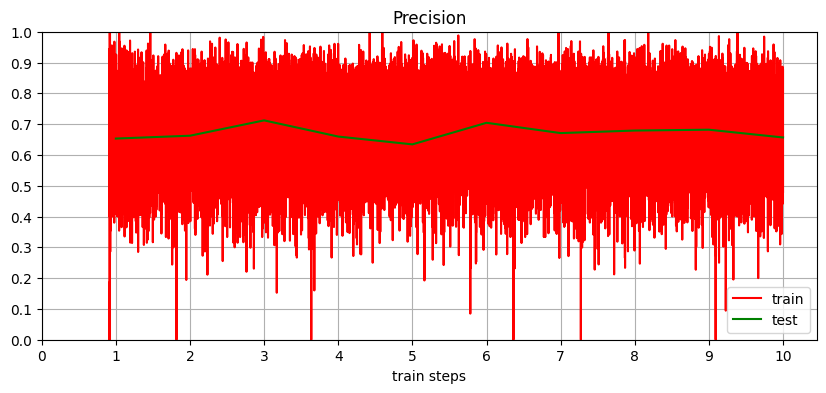

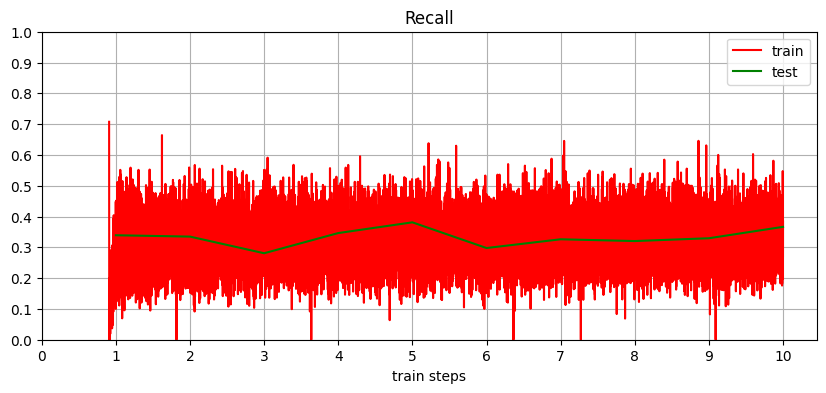

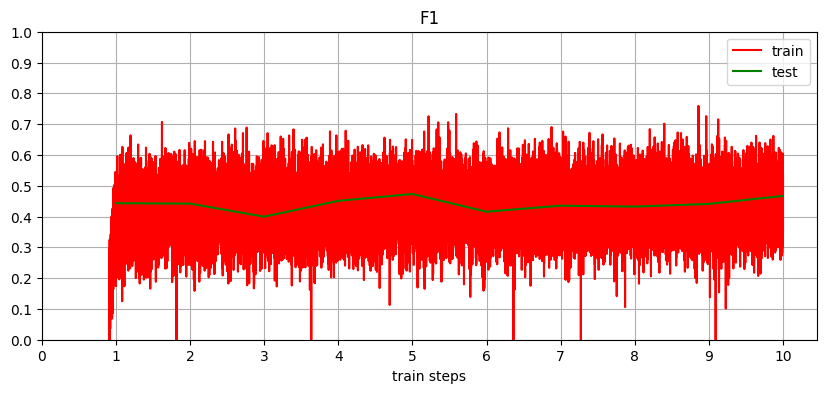

Time:  17.609382553895315
Epoch 10: ROC-AUC = 92.62%
Epoch 10: Precision = 0.657
Epoch 10: Recall = 0.366
Epoch 10: F1-score = 0.467
Final ROC-AUC = 92.62%
Final Precision = 0.657
Final Recall = 0.366
Final F1-score = 0.467
CPU times: user 28min 55s, sys: 7min 12s, total: 36min 7s
Wall time: 3h 16min 32s


In [27]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = GraphZSAGEConvBatchNorm()
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10)
    

In [28]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 4
Max F1-score: 47.3134%
ROC-AUC: 92.2041%
Precision: 0.6343
Recall: 0.3811
Mean time for 1 epoch 19.63 minutes


# Запуск GraphZSAGEConvLayerNorm

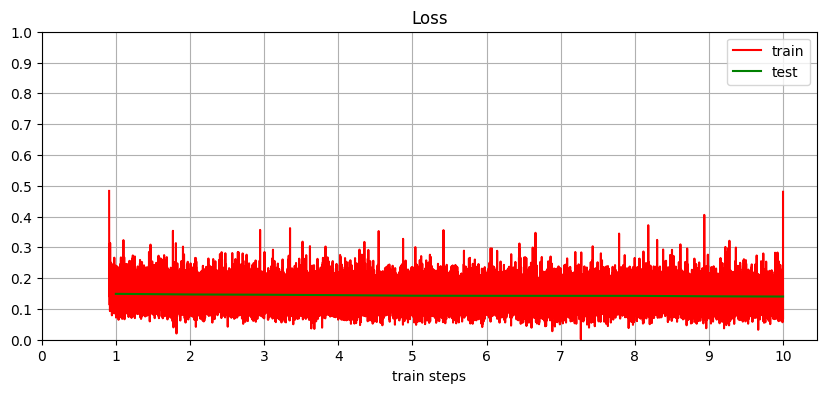

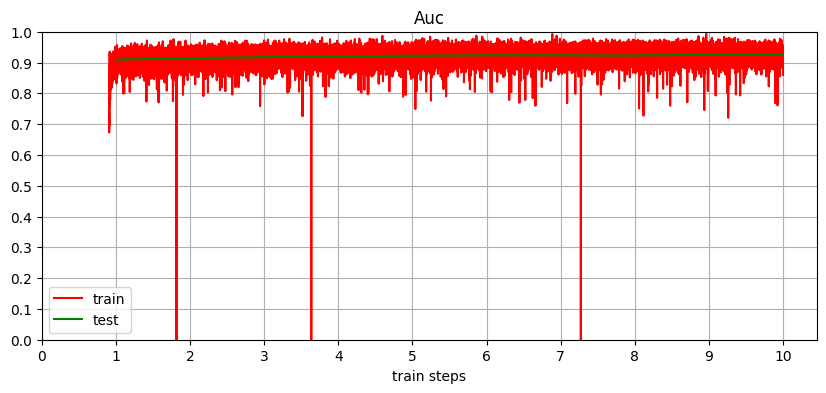

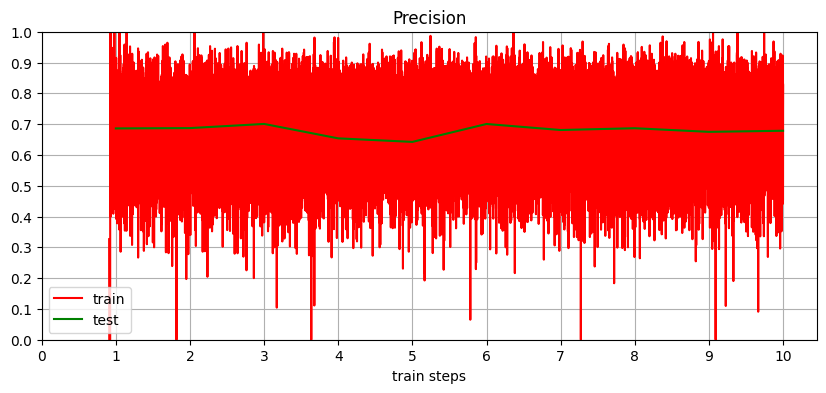

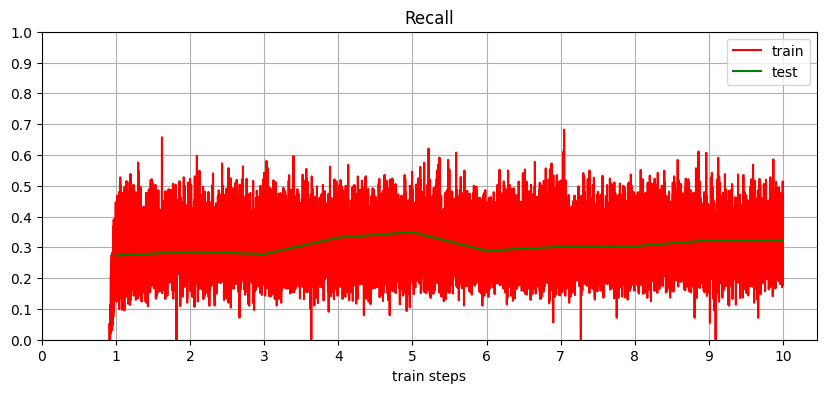

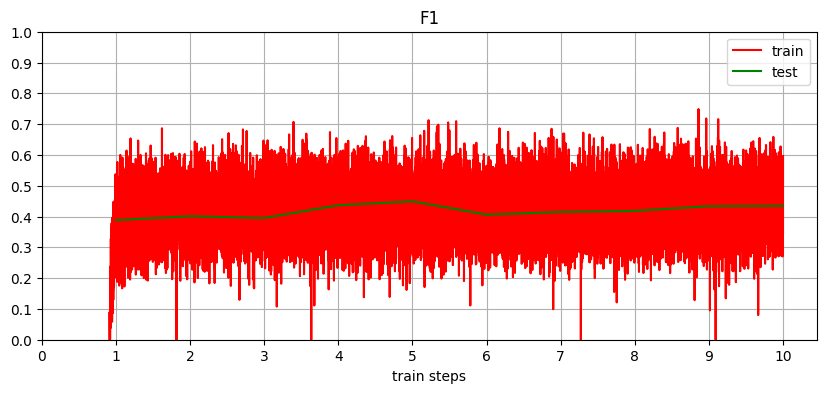

Time:  17.14884585936864
Epoch 10: ROC-AUC = 92.57%
Epoch 10: Precision = 0.678
Epoch 10: Recall = 0.324
Epoch 10: F1-score = 0.435
Final ROC-AUC = 92.57%
Final Precision = 0.678
Final Recall = 0.324
Final F1-score = 0.435
CPU times: user 27min 28s, sys: 7min 29s, total: 34min 57s
Wall time: 2h 55min 47s


In [49]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = GraphZSAGEConvLayerNorm()
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10)
    

In [50]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 5
Max F1-score: 0.4494
ROC-AUC: 0.9221
Precision: 0.6423
Recall: 0.3492
Mean time for 1 epoch 17.56 minutes


# Запуск GraphZSAGEConvGroupNorm

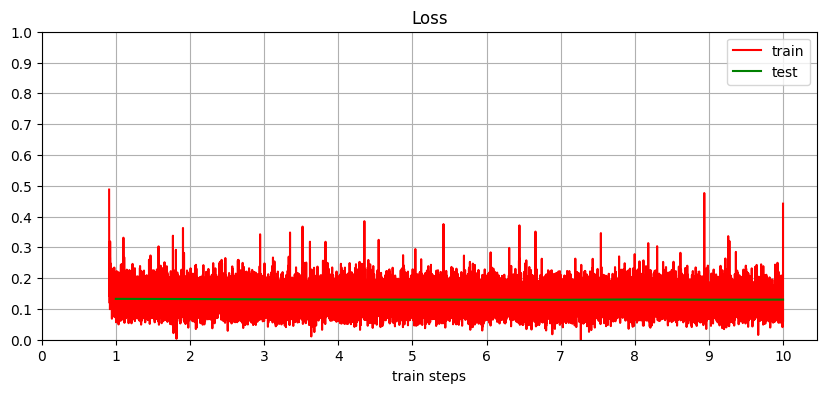

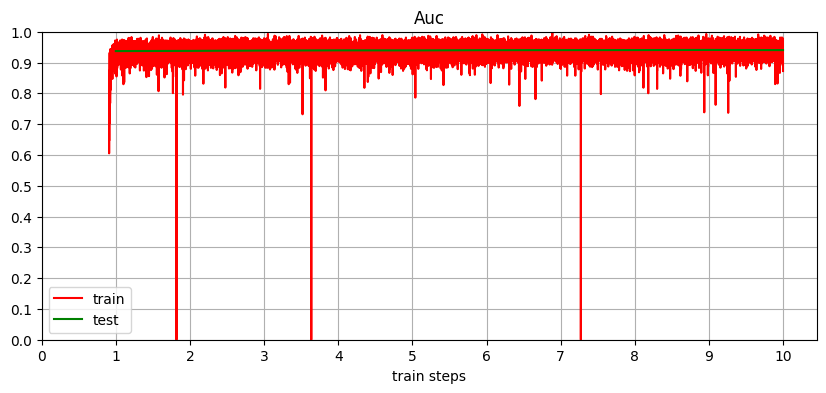

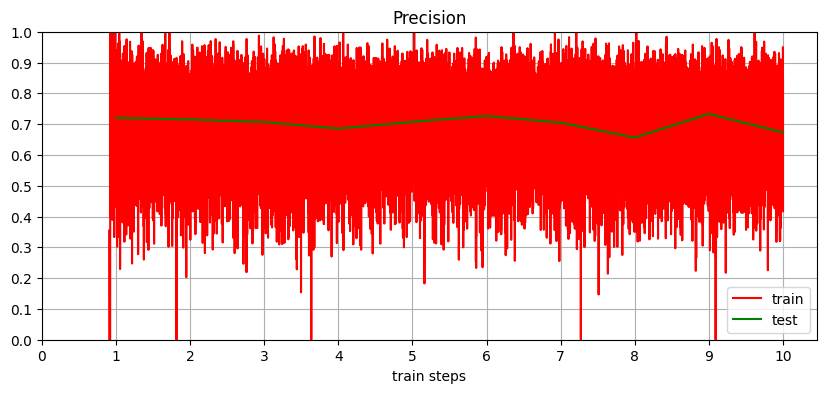

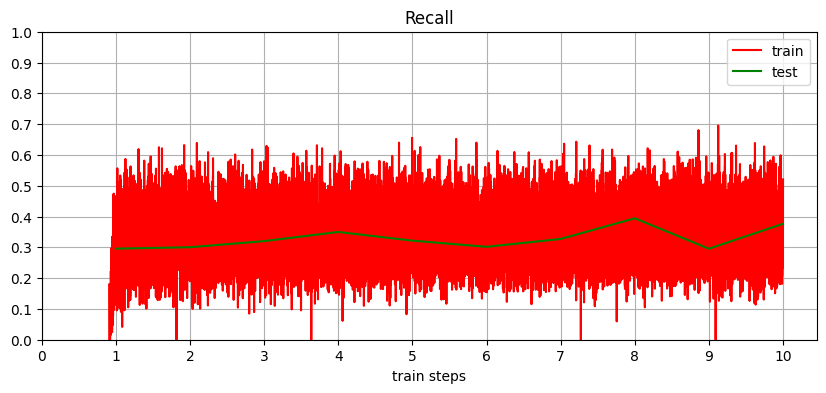

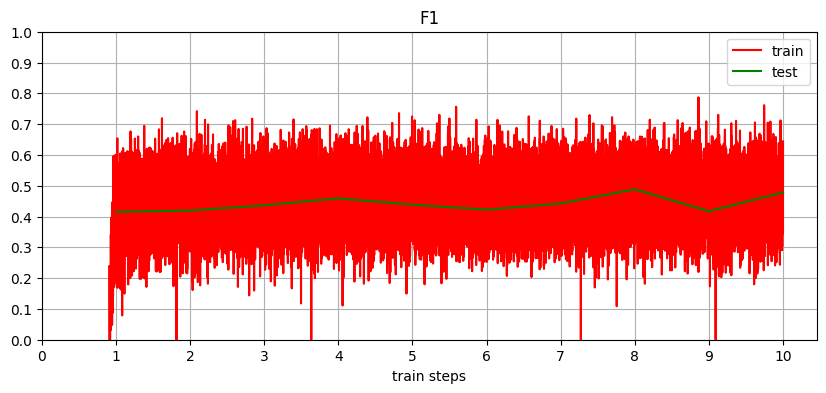

Time:  17.02558019955953
Epoch 10: ROC-AUC = 94.03%
Epoch 10: Precision = 0.673
Epoch 10: Recall = 0.376
Epoch 10: F1-score = 0.478
Final ROC-AUC = 94.03%
Final Precision = 0.673
Final Recall = 0.376
Final F1-score = 0.478
CPU times: user 28min 38s, sys: 7min 35s, total: 36min 14s
Wall time: 2h 56min 11s


In [44]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = GraphZSAGEConvGroupNorm()
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10)
    

In [45]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 0.4884
ROC-AUC: 0.9405
Precision: 0.6564
Recall: 0.3943
Mean time for 1 epoch 17.60 minutes


# Запуск GraphZSAGEConvInstanceNorm

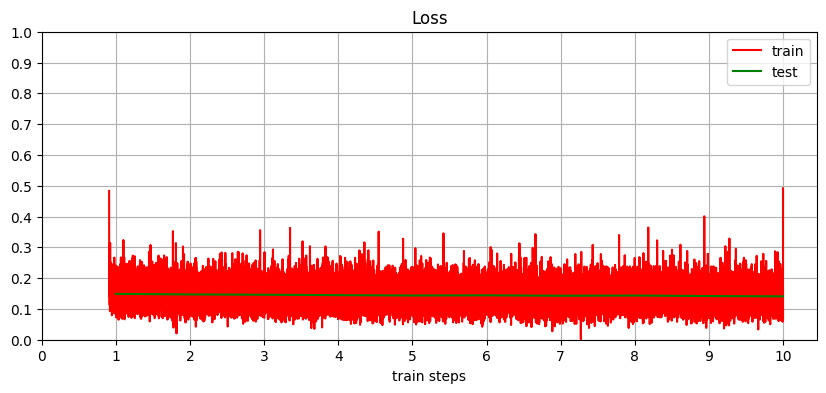

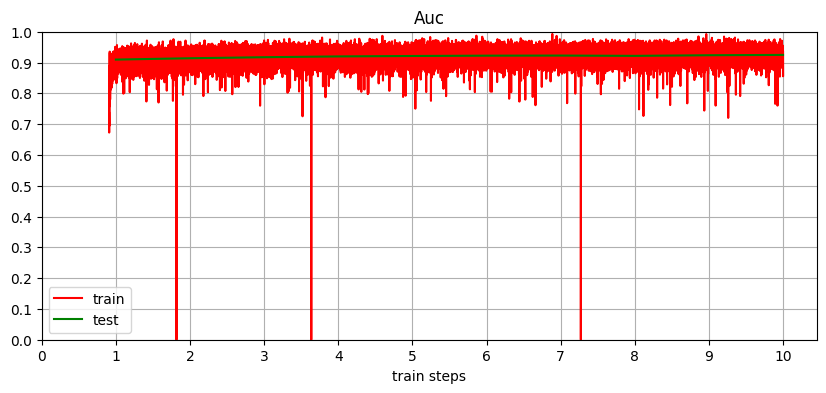

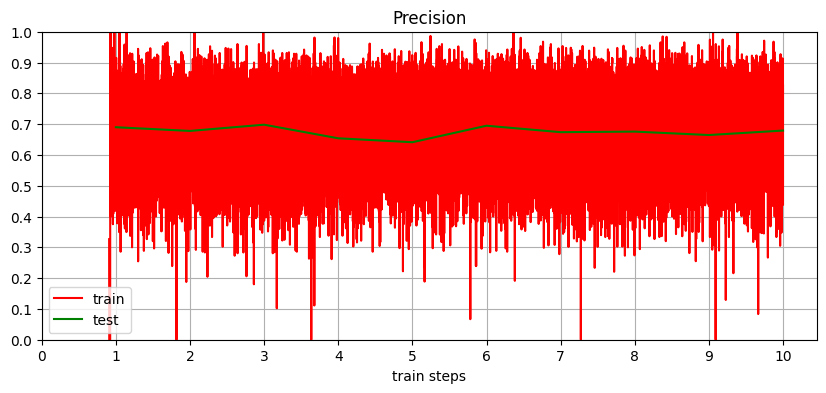

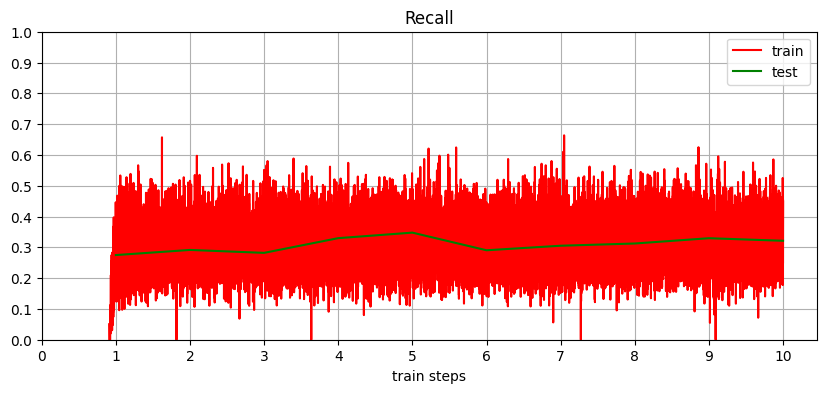

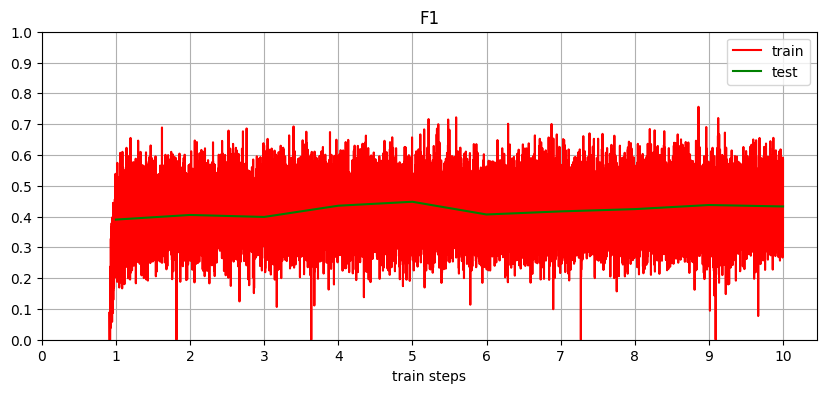

Time:  15.350325667858124
Epoch 10: ROC-AUC = 92.47%
Epoch 10: Precision = 0.679
Epoch 10: Recall = 0.321
Epoch 10: F1-score = 0.433
Final ROC-AUC = 92.47%
Final Precision = 0.679
Final Recall = 0.321
Final F1-score = 0.433
CPU times: user 24min 38s, sys: 6min 38s, total: 31min 16s
Wall time: 2h 47min 2s


In [46]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = GraphZSAGEConvInstanceNorm()
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10)
    

In [47]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 5
Max F1-score: 0.4479
ROC-AUC: 0.9212
Precision: 0.6413
Recall: 0.3477
Mean time for 1 epoch 16.68 minutes


# Dropout

In [53]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphZSAGEConvGroupNormDropout(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvGroupNormDropout, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.gn1 = torch.nn.GroupNorm(num_groups=50, num_channels=500)  # GroupNorm после conv1
        self.conv2 = SAGEConv(500, 100)
        self.gn2 = torch.nn.GroupNorm(num_groups=10, num_channels=100)  # GroupNorm после conv2
        self.conv3 = SAGEConv(100, 2)
        
    def forward(self, x):  # Добавил edge в аргументы (ранее он был не объявлен)
        # Первый слой
        x = self.conv1(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)  # [B, F, N]
        x = self.gn1(x)
        x = x.permute(0, 2, 1)  # обратно [B, N, F]
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Второй слой
        x = self.conv2(x, edge.to('cuda:1'))
        x = x.permute(0, 2, 1)  # [B, F, N]
        x = self.gn2(x)
        x = x.permute(0, 2, 1)  # обратно [B, N, F]
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Третий слой (без норм. и активации перед log_softmax)
        x = self.conv3(x, edge.to('cuda:1'))
        
        return F.log_softmax(x, dim=-1)

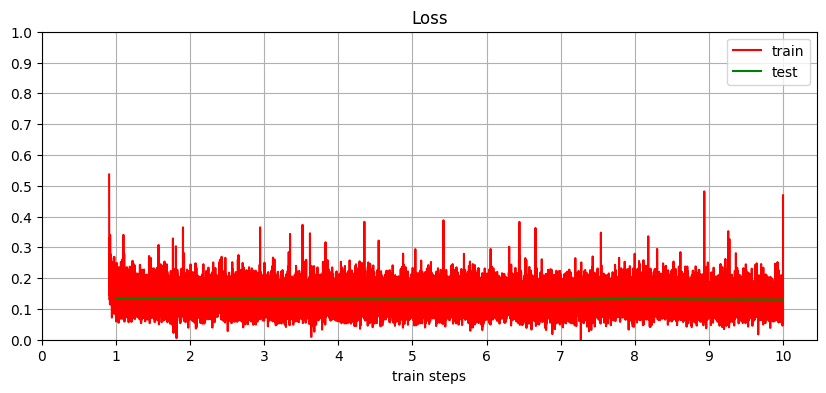

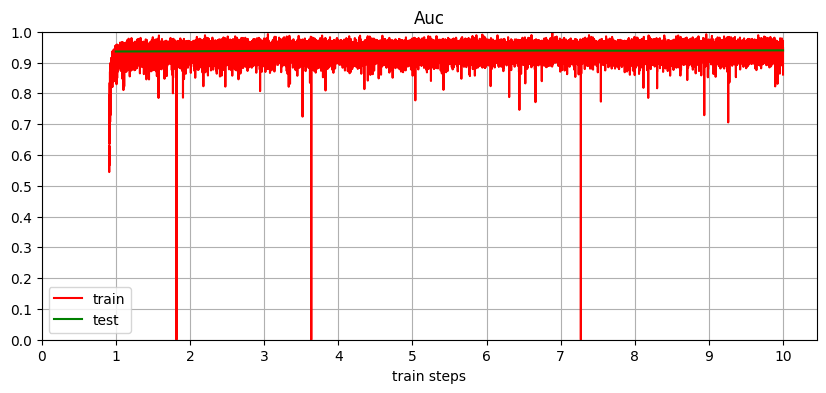

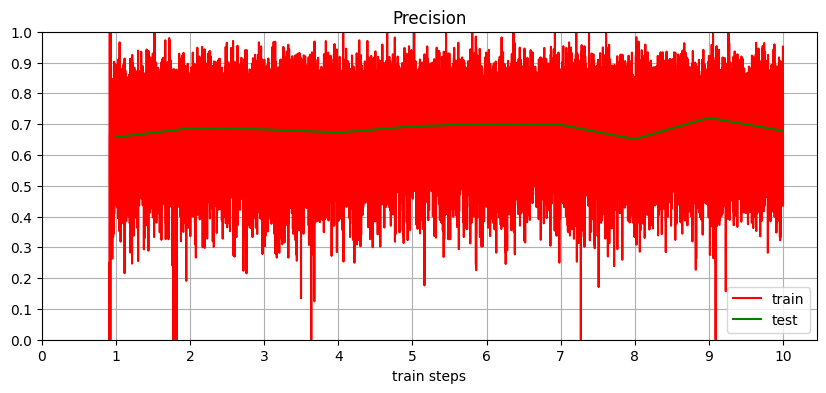

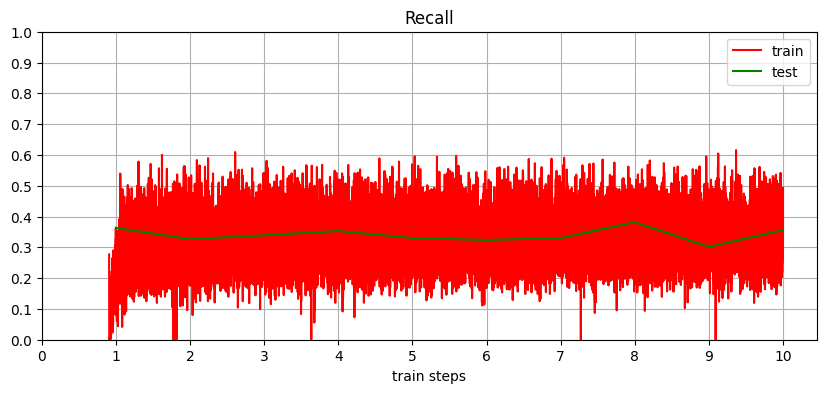

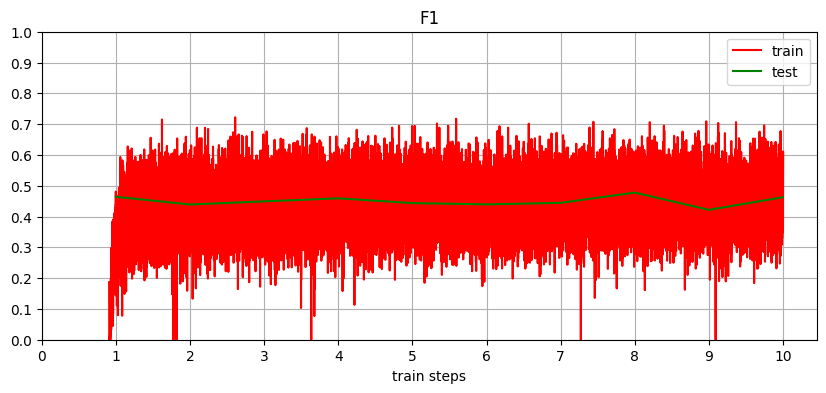

Time:  17.02622859875361
Epoch 10: ROC-AUC = 93.96%
Epoch 10: Precision = 0.678
Epoch 10: Recall = 0.356
Epoch 10: F1-score = 0.463
Final ROC-AUC = 93.96%
Final Precision = 0.678
Final Recall = 0.356
Final F1-score = 0.463
CPU times: user 28min 46s, sys: 7min 42s, total: 36min 29s
Wall time: 2h 56min 19s


In [54]:
%%time

device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = GraphZSAGEConvGroupNormDropout()
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10)
    

In [55]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 0.4777
ROC-AUC: 0.9383
Precision: 0.6512
Recall: 0.3816
Mean time for 1 epoch 17.61 minutes
